## TODO
1. Проверить sound banks не на линухе, м.б. экспортнуть сразу в гитарпро на винде, т.к. на линухе все играет стандартное пианино.
2. Если экспортировать в drum не получится - перевести все ноты в набор основных звуков: кик, снейр, хэт, крэш и т.д., то, что есть в music21
3. Val loss всегда растет независимо от архитектуры. М.б. стоит избавиться от пауз, которые составляют 40 % партий и добавить конкатенацию с массивом длительностей
4. Или просто добавить больше партий?

In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm
import guitarpro

import matplotlib.pyplot as plt

from src.model import NotesRNN
from src.parse_gp import get_drum_notes, drop_rests_from_drum_track, get_notes_and_durations
from src.save_midi import save_notes_and_durations, save_notes

In [2]:
folderpath = "tabs/"
use_durations = True

In [10]:
# notes = []
# for folder in os.listdir(folderpath):
#     for filename in tqdm(os.listdir(folderpath + folder + '/')):
#         tab = guitarpro.parse(folderpath + folder + '/' + filename)
#         notes += get_drum_notes(tab, True)

notes, durations = [], []
for folder in os.listdir(folderpath):
    for filename in tqdm(os.listdir(folderpath + folder + '/')):
        tab = guitarpro.parse(folderpath + folder + '/' + filename)
        tab_notes, tab_durations = get_notes_and_durations(tab, False)
        notes += tab_notes
        durations += tab_durations

  0%|          | 0/12 [00:00<?, ?it/s]

In [11]:
len(notes) == len(durations)

True

In [12]:
# if use_durations:
#     notes, durations = drop_rests_from_drum_track(notes)

In [13]:
note_dictionary = {note: i for i, note in enumerate(set(notes))}
inv_note_dictionary = {i: note for note, i in note_dictionary.items()}
notes_to_int = [note_dictionary[note] for note in notes]
notes_to_int[:10]

[3, 124, 25, 0, 25, 126, 0, 25, 25, 0]

In [14]:
notes[:10]

['del', '46.36.', '42.', '', '42.', '51.40.', '', '42.', '42.', '']

In [15]:
len(note_dictionary)

184

In [16]:
if use_durations:
    duration_dictionary = {dur: i for i, dur in enumerate(set(durations))}
    inv_dur_dictionary = {i: dur for dur, i in duration_dictionary.items()}
    durations_to_int = [duration_dictionary[dur] for dur in durations]
    durations_to_int[:10]
    print(len(duration_dictionary))
else:
    durations_to_int = None

6


In [17]:
n_notes = len(note_dictionary)
n_durations = len(duration_dictionary) if use_durations else None
emb_size = 64
n_units = 64
n_layers = 2
use_dropout = True
use_attention = True

In [18]:
RNN = NotesRNN(
    n_notes,
    n_durations,
    emb_size,
    n_units,
    n_layers,
    use_dropout,
    use_attention,
    use_durations
)

In [19]:
RNN.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     11776       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     384         input_2[0][0]                    
______________________________________________________________________________________________

In [20]:
seq_length = 64
step = 1
X, y = RNN.prepare_sequences(notes_to_int, durations_to_int, seq_length, step)

In [22]:
RNN.model.fit(
    X, y,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/10
457/457 [==============================] - 15s 33ms/step - loss: 3.0411 - dense_1_loss: 2.8991 - dense_2_loss: 0.1420 - val_loss: 2.8231 - val_dense_1_loss: 2.7133 - val_dense_2_loss: 0.1098
Epoch 2/10
457/457 [==============================] - 14s 31ms/step - loss: 2.7782 - dense_1_loss: 2.6702 - dense_2_loss: 0.1080 - val_loss: 2.8016 - val_dense_1_loss: 2.6907 - val_dense_2_loss: 0.1109
Epoch 3/10
457/457 [==============================] - 14s 31ms/step - loss: 2.6865 - dense_1_loss: 2.5921 - dense_2_loss: 0.0943 - val_loss: 2.8079 - val_dense_1_loss: 2.6952 - val_dense_2_loss: 0.1127
Epoch 4/10
457/457 [==============================] - 14s 30ms/step - loss: 2.6326 - dense_1_loss: 2.5472 - dense_2_loss: 0.0853 - val_loss: 2.8986 - val_dense_1_loss: 2.7703 - val_dense_2_loss: 0.1283
Epoch 5/10
457/457 [==============================] - 14s 31ms/step - loss: 2.5931 - dense_1_loss: 2.5149 - dense_2_loss: 0.0782 - val_loss: 2.7774 - val_dense_1_loss: 2.6754 - val_dense_2_los

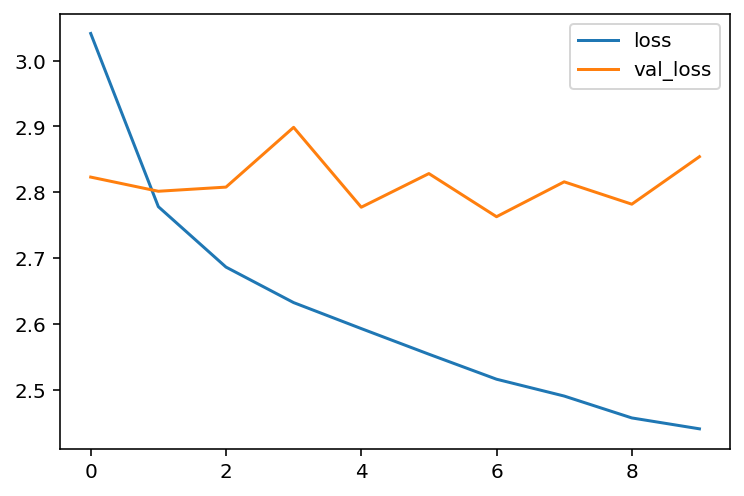

In [23]:
plt.figure()
plt.plot(RNN.model.history.history['loss'], label='loss')
plt.plot(RNN.model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [24]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [25]:
if use_durations:
    self_notes = [
        '46.36.', '46.36.', '46.38.', '46.36.', '38.', '46.36.', '38.', '46.36.', '46.38.', '46.36.', '38.',
        '46.36.', '46.36.', '46.38.', '46.36.', '38.', '46.36.', '38.', '46.36.', '46.38.', '46.36.', '38.',
    ]
    self_durations = [
        1/8, 1/8, 1/8, 1/16, 1/16, 1/16, 1/16, 1/8, 1/8, 1/16, 1/16,
        1/8, 1/8, 1/8, 1/16, 1/16, 1/16, 1/16, 1/8, 1/8, 1/16, 1/16
    ]
    generated_notes = [note_dictionary[x] for x in self_notes]
    generated_durations = [duration_dictionary[x] for x in self_durations]
    generated = [generated_notes, generated_durations]
else:
    self_notes = [
        '46.36.', '', '46.36.', '', '46.38.', '', '46.36.', '38.', '46.36.', '38.', '46.36.', '', '46.38.', '', '46.36.', '38.',
        '46.36.', '', '46.36.', '', '46.38.', '', '46.36.', '38.', '46.36.', '38.', '46.36.', '', '46.38.', '', '46.36.', '38.',
    ]
    generated = [note_dictionary[x] for x in self_notes]

In [26]:
temperature = 0.5
n_generated = 100

att_matrix = np.zeros((n_generated+seq_length, n_generated))

for i in tqdm(range(n_generated)):
    if use_durations:
        note_pred, duration_pred = RNN.model.predict([np.array(generated[0][i:]), np.array(generated[1][i:])])
        generated[0].append(sample(note_pred[0], temperature))
        generated[1].append(sample(duration_pred[0], temperature))
    else:
        note_pred = RNN.model.predict([generated[i:]])
        generated.append(sample(note_pred[0], temperature))
#     if use_attention:
#         att_preds = RNN.att_model.predict(generated[i:])[0]
#         att_matrix[(i-len(att_preds)+seq_length):(i+seq_length), i] = att_preds

  0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
if use_durations:
    generated_to_notes = [inv_note_dictionary[i] for i in generated[0]]
    generated_to_durations = [inv_dur_dictionary[i] for i in generated[1]]
else:
    generated_to_notes = [inv_note_dictionary[i] for i in generated]
generated_to_notes[64:78]

['42.',
 '',
 '44.',
 '43.',
 '49.',
 '52.36.',
 '55.40.',
 '40.36.',
 '43.40.36.',
 '40.',
 '49.36.',
 '55.43.36.',
 '',
 '36.']

In [29]:
if use_durations:
    generated = [generated_to_notes, generated_to_durations]
else:
    generated = generated_to_notes

In [30]:
save_notes_and_durations(generated, 'output')
#save_notes(generated, 'output')

In [20]:
# if use_attention:
#     fig, ax = plt.subplots(figsize=(20,20))
#     im = ax.imshow(att_matrix[(seq_length-2):,], cmap='coolwarm', interpolation='nearest')
#     ax.set_xticks(np.arange(-.5, len(generated_to_notes)- seq_length, 1), minor=True);
#     ax.set_yticks(np.arange(-.5, len(generated_to_notes)- seq_length, 1), minor=True);
#     ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
#     ax.set_xticks(np.arange(len(generated_to_notes) - seq_length))
#     ax.set_yticks(np.arange(len(generated_to_notes)- seq_length+2))
#     ax.set_xticklabels([n for n in generated_to_notes[(seq_length):]])
#     ax.set_yticklabels([n for n in generated_to_notes[(seq_length - 2):]])
#     ax.xaxis.tick_top()    
#     plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va = "center",
#              rotation_mode="anchor")

#     plt.show()